In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# 1. К алгоритму kNN реализуйте добавление весов для соседей по любому из показанных на уроке принципов. Сравните точность нового алгоритма с исходным при разных значениях k.

Загрузим один из "игрушечных" датасетов из sklearn и для наглядности возьмем только первые два признака (всего в датасете их 4):

In [2]:
X, y = load_iris(return_X_y=True)
X = X[:, :2]

Разделим выборку на обучающую и тестовую:

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1)

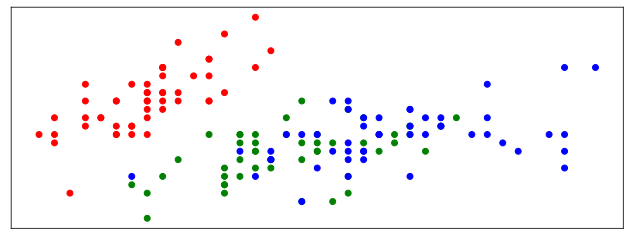

In [4]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(11, 4))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)
plt.xticks([])
plt.yticks([]);

Используем Евклидову метрику. Реализуем функцию для ее подсчета:

In [5]:
def e_metrics(x1, x2):
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    return np.sqrt(distance)

Реализуем алгоритм поиска k ближайших соседей:

In [6]:
def knn(x_train, y_train, x_test, k, w=0):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # отберем k ближайших соседей
        k_neighbours = sorted(test_distances)[0:k]
                
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in k_neighbours:
            if w == 1:
                classes[d[1]] += 1 * (0.5 ** k_neighbours.index(d))  # вес 1 * q^i
            elif w == 2:
                classes[d[1]] += 1 / (k_neighbours.index(d) + 1)  # вес 1/i
            elif w == 3:
                classes[d[1]] += 1 * (0.5 ** d[1])  # вес 1 * q^d
            elif w == 4:
                classes[d[1]] += (k+1-k_neighbours.index(d))/k  # вес (k+1-i)/k
            else:
                classes[d[1]] += 1 # вес каждого соседа равен 1
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

Напишем функцию для вычисления точности:

In [7]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Проверим работу алгоритма при различных значениях k:

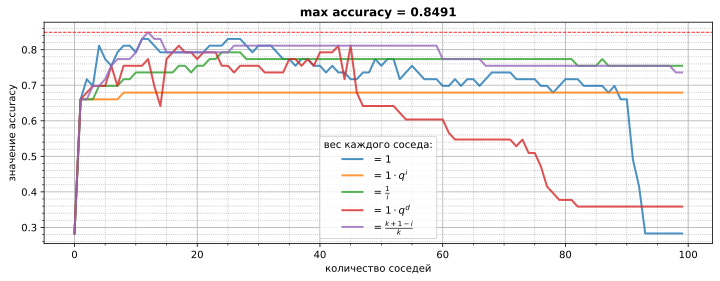

In [8]:
count_k = 100
accuracy_w0 = [accuracy(knn(X_train, y_train, X_test, k=i), y_test) for i in range(count_k)]
accuracy_w1 = [accuracy(knn(X_train, y_train, X_test, k=i, w=1), y_test) for i in range(count_k)]
accuracy_w2 = [accuracy(knn(X_train, y_train, X_test, k=i, w=2), y_test) for i in range(count_k)]
accuracy_w3 = [accuracy(knn(X_train, y_train, X_test, k=i, w=3), y_test) for i in range(count_k)]
accuracy_w4 = [accuracy(knn(X_train, y_train, X_test, k=i, w=4), y_test) for i in range(count_k)]

max_acc = 0
for i in [max(accuracy_w0), max(accuracy_w1), max(accuracy_w2), max(accuracy_w3), max(accuracy_w4)]:
    if max_acc < i:
        max_acc = i

plt.figure(figsize=(12, 4))
plt.plot(accuracy_w0, label=' = 1', alpha=0.8, lw=2)
plt.plot(accuracy_w1, label=' = $ 1 \cdot q^i$', alpha=0.8, lw=2)
plt.plot(accuracy_w2, label=' = $ \\frac{1}{i}$', alpha=0.8, lw=2)
plt.plot(accuracy_w3, label=' = $ 1 \cdot q^d$', alpha=0.8, lw=2)
plt.plot(accuracy_w4, label=' = $ \\frac{k+1-i}{k}$', alpha=0.8, lw=2)
plt.axhline(y=max_acc, c='r', linestyle='--', lw=0.9)

plt.minorticks_on()
plt.legend(title='вес каждого соседа:')
plt.xlabel('количество соседей')
plt.ylabel('значение accuracy')
plt.title(f'max accuracy = {max_acc:.4f}', fontweight='bold')

plt.grid(which='major')
plt.grid(which='minor', linestyle=':');

**Вывод**: применение "взвешенного голосования" к алгоритму ```KNN``` и подбор оптимального количества соседей влияют на точность алгоритма. Правильно подобранные веса могут поддерживать точность даже при указании значения гиперпараметра $k$ выше количества элементов в выборке (а у нас в тестовой выборке было 53 элемента). 

Мы рассмотрели 5 значений весов соседей:

1) $w(i) = 1$ (один вес для всех)

2) $w(i) = q^{i}$,   $q \in (0,1)$

3) $w(i) = \frac{1}{i}$

4) $w(i) = q^{d}$,   $q \in (0,1)$

5) $w(i) = \frac{k + 1 - i}{k}$

лучший результат показал вес $w(i) = \frac{k + 1 - i}{k}$ при количестве соседей $k=12$, accuracy = 0.8491

# 2.* Напишите функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и постройте график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока.

Вначале сгенерируем три облака точек с помощью инструментов `sklearn` (+ добавим чуть большей рассеянности точкам):

In [9]:
from sklearn.datasets import make_blobs
import random

X, y = make_blobs(n_samples=100, cluster_std=1.5, random_state=47)

Такое получилось облако точек:

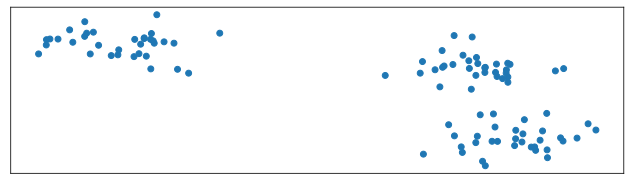

In [10]:
plt.figure(figsize=(11, 3))
plt.scatter(X[:, 0], X[:, 1])
plt.xticks([])
plt.yticks([]);

В цикле на точечных диаграммах посмотрим на поведение алгоритма с изменением количества кластеров:
- но без возможности изменения количества итераций 
- и с изменением итераций. 

_____

Вот код основного цикла алгоритма. Поиск определения трёх центроид в нём происходит по такой логике: 
- сортируем массив 
- режем на равные чати 
- берём первый элемент от каждого "отрезка"

In [11]:
def kmeans(data, max_iterations, min_distance, k):

    # инициализируем центроиды. Их количество k определяется как первый элемент "порезанного" массива
    data = np.sort(data, axis=1)
    centroids = [i[0] for i in np.array_split(data, k)]
    
    for i in range(max_iterations):
        # Создадим словарь для классификации
        classes = {i: [] for i in range(k)}
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
              
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        
        for ind in range(len(centroids)):
            distance = e_metrics(centroids[ind], old_centroids[ind])
            if distance > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            print('stop:', i)
            break
    
    return old_centroids, classes

В функцию для визуализации кластеров добавим цветов, это позволит увеличить количество итераций с прибавлением кластеров:

In [12]:
def visualize(centroids, classes, quality_max_iterat=False):
    list_colors = ['#C0392B', '#9B59B6', '#2980B9', '#1ABC9C', '#F1C40F', 
                   '#E67E22', '#B3B6B7', '#707B7C', '#212F3D', '#156EF0',
                   '#641E16', '#512E5F', '#154360', '#0E6251', '#7D6608', 
                   '#6E2C00', '#4D5656', '#D6DBDF', '#17202A', '#D2B4DE']
    
    plt.figure(figsize=(11, 3))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    count_color=0
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=list_colors[class_item], alpha=0.8)
            plt.xticks([])
            plt.yticks([])
        count_color += 1
    if quality_max_iterat:
        plt.title(f'количество кластеров = {count_color}, '
                  f'качество = {quality_max_iterat[0]:.4f}, '
                  f'максимум итераций = {quality_max_iterat[1]}', fontweight='bold')
    else:
        plt.title(f'количество кластеров = {count_color}', fontweight='bold')
            
    plt.show()

А вот и функция качества - среднее квадратичное расстояние внутри каждого кластера, просуммированное по всем кластерам:

In [13]:
def quality(centroids, clusters):
    
    result_list, k = [], len(clusters)
    
    for сluster in range(k):
        quality = 0
        
        for elem in range(len(clusters[сluster])):
            
            distances = e_metrics(clusters[сluster][elem], centroids[сluster])
            quality += distances ** 2
        result_list.append(quality / len(clusters[сluster])) 
    return np.sum(result_list) 

Определим минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм как 1e-4:

In [14]:
min_distance = 1e-4

Первым делом попробуем менять в цикле количество кластеров, но не количество итераций (оставим одну). Пройдёмся в цикле по количеству кластеров от 1 до 10-ти и посмотрим сначала на отдельных диаграммах, а потом на графике изменения ошибки, как менялось качество разбиения на кластеры:

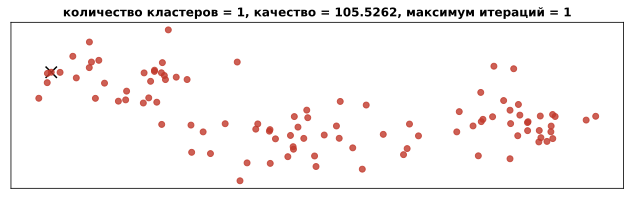

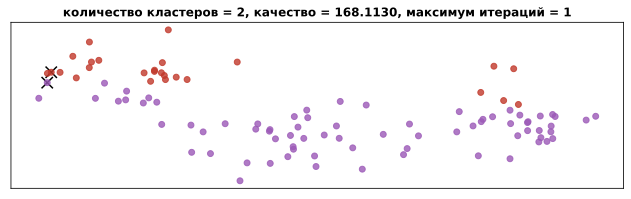

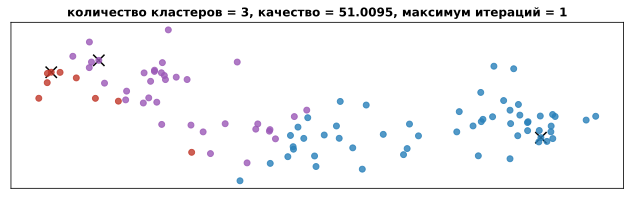

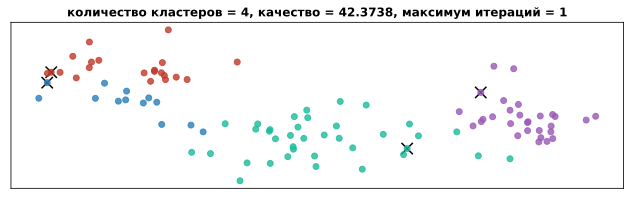

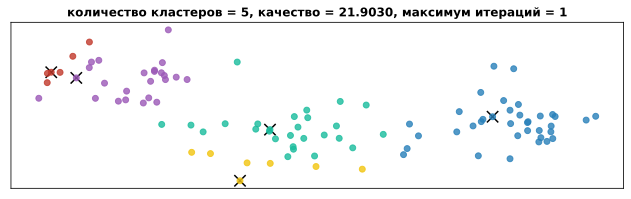

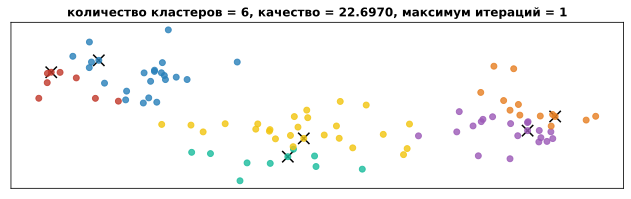

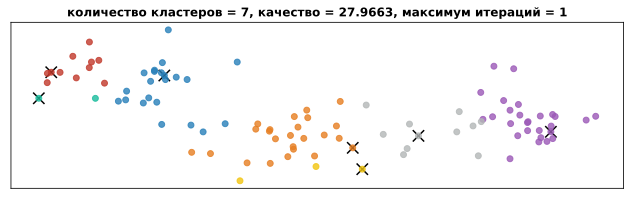

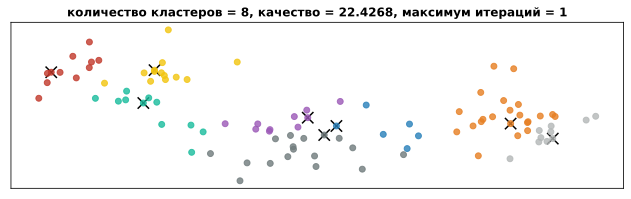

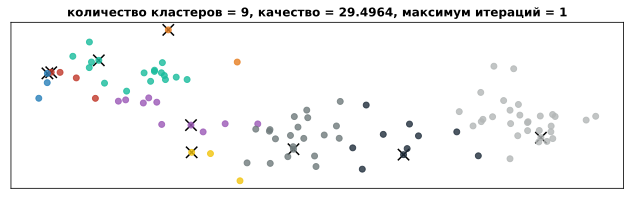

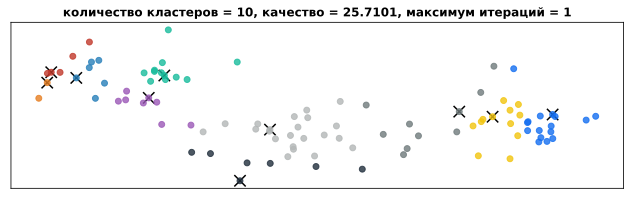

In [15]:
max_iterations = 1
quality_list = []
for i in range(1, 11):
    centroids, clusters = kmeans(X, max_iterations, min_distance, k=i)
    q = quality(centroids, clusters)
    quality_list.append(q)
    visualize(centroids, clusters, quality_max_iterat=(q, max_iterations))

Теперь построим график, на котором посмотрим изменение качества в завсимости от количества кластеров:

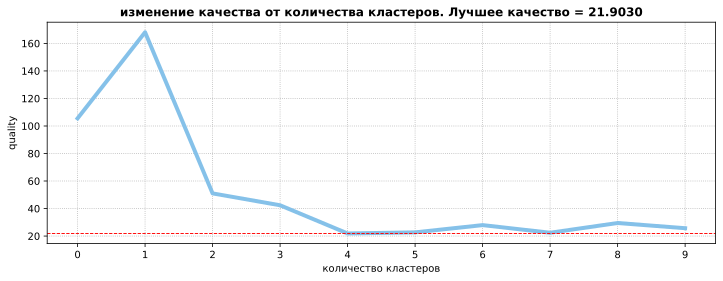

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(quality_list, c='#85C1E9', lw=4)
plt.axhline(y=min(quality_list), c='r', linestyle='--', lw=0.9)
plt.xticks(range(len(quality_list)))

plt.xlabel('количество кластеров')
plt.ylabel('quality')
plt.title(f'изменение качества от количества кластеров. Лучшее качество = {min(quality_list):.4f}',
          fontweight='bold')

plt.grid(linestyle=':');

А теперь добавим возможность увеличивать количество итераций до 10-ти и построим те же графики и посчитаем то же качество: 

stop: 1


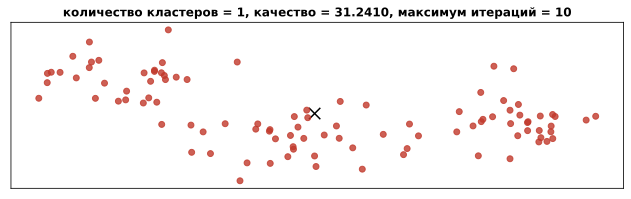

stop: 4


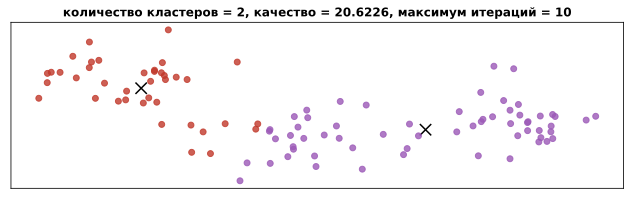

stop: 7


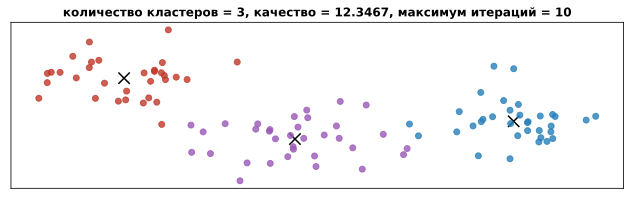

stop: 4


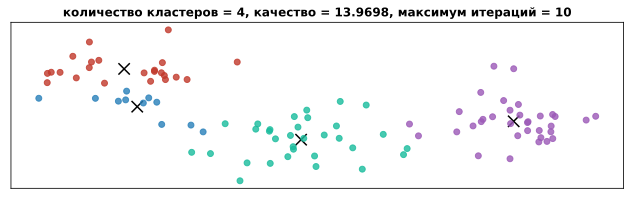

stop: 9


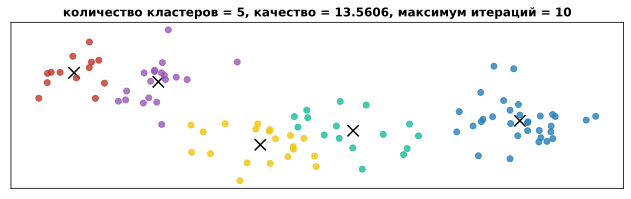

stop: 4


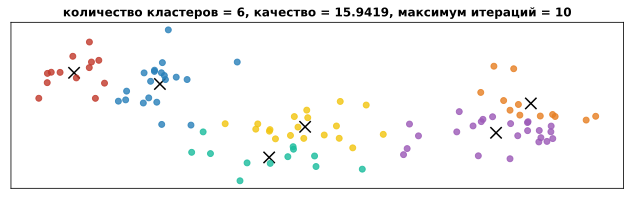

stop: 5


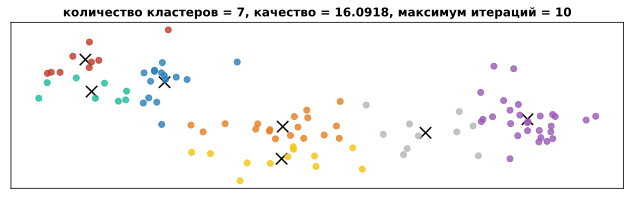

stop: 4


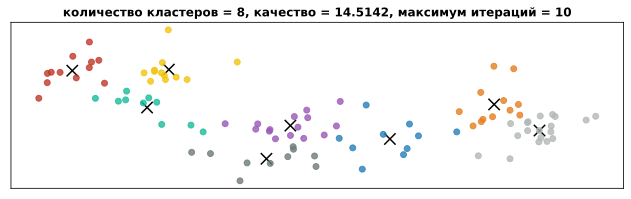

stop: 3


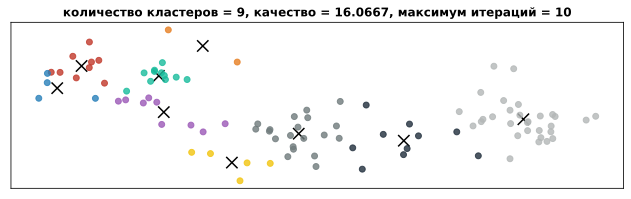

stop: 6


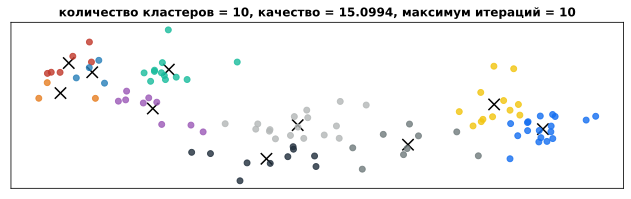

In [17]:
max_iterations = 10
quality_list = []
for i in range(1, 11):
    centroids, clusters = kmeans(X, max_iterations, min_distance, k=i)
    q = quality(centroids, clusters)
    quality_list.append(q)
    visualize(centroids, clusters, quality_max_iterat=(q, max_iterations))

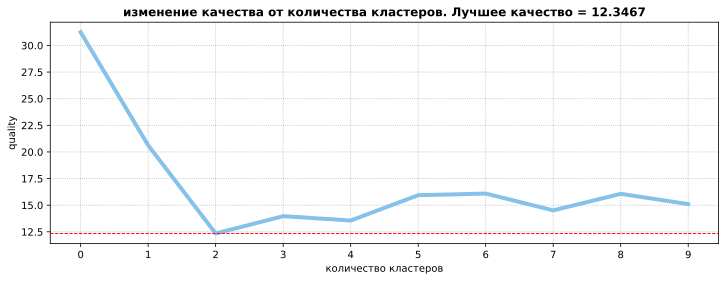

In [18]:
plt.figure(figsize=(12, 4))
plt.plot(quality_list, c='#85C1E9', lw=4)
plt.axhline(y=min(quality_list), c='r', linestyle='--', lw=0.9)
plt.xticks(range(len(quality_list)))

plt.xlabel('количество кластеров')
plt.ylabel('quality')
plt.title(f'изменение качества от количества кластеров. Лучшее качество = {min(quality_list):.4f}',
          fontweight='bold')

plt.grid(linestyle=':');

**Вывод:** алгоритм K-means показывает лучшее качество кластеризации и ведёт себя более предсказуемо при возможности добавления количества итераций c пересчётом центроид. При таком подходе лучшее качество составило 12.35 на трёх кластерах после 7-ми итераций. И  диаграмма рассеяния с выделенными цветом кластерами выглядят наглядно и понятно:

![k_means_best.jpg](https://ltdfoto.ru/images/2023/03/09/k_means_best.jpg)

А вот K-means без возможности итераций на тех же данных показал лучшее качество = 21.90 при пяти кластерах.

В обоих случаях графики довольно быстро достигли "локтя", после которого качество перестало существенно меняться, но с возможностью добавления итераций это произошло предсказуемо быстрее.